In [1]:
seed = 0
import random
import numpy as np
import tensorflow as tf
import os
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["PYTHONHASHSEED"] = str(seed)

os.environ['TF_DETERMINISTIC_OPS'] = '1'


In [3]:
import numpy as np
import pandas as pd
# 选择比较好的模型
import seaborn as sns

import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import resample

from sklearn.model_selection import StratifiedKFold
import os
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
%load_ext autoreload
%autoreload 2

def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {
        0: 'A_1', 1: 'B_2', 2: 'A_3', 3: 'A_4', 4: 'B_3', 5: 'C_5', 6: 'C_2', 7: 'A_5', 8: 'B_1', 
        9: 'C_1', 10: 'A_2', 11: 'C_3',12: 'B_5', 13: 'B_4', 14: 'C_4', 
        15: 'D_6', 16: 'E_7', 17: 'F_8', 18: 'G_9', 19: 'H_0'
              }
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0
sample_num = 60

In [5]:
root_path  = '../data/'
train = pd.read_csv(root_path+'sensor_train_final.csv')
test = pd.read_csv(root_path+'sensor_test_final.csv')
sub = pd.read_csv(root_path+'submit_example.csv')
y = train.groupby('fragment_id')['behavior_id'].min()
# data_test['fragment_id'] += 100000
label = 'behavior_id'

In [6]:


def add_features(df):
    print(df.columns)
    df['acc'] = (df.acc_x ** 2 + df.acc_y ** 2 + df.acc_z ** 2) ** .5
    df['accg'] = (df.acc_xg ** 2 + df.acc_yg ** 2 + df.acc_zg ** 2) ** .5
#     df['thetax']=np.arctan(df.acc_xg/
#                            np.sqrt(df.acc_yg*df.acc_yg+df.acc_zg*df.acc_zg))*180/np.pi
#     df['thetay']=np.arctan(df.acc_yg/
#                            np.sqrt(df.acc_xg*df.acc_xg+df.acc_zg*df.acc_zg))*180/np.pi
#     df['thetaz']=np.arctan(df.acc_zg/
#                            np.sqrt(df.acc_yg*df.acc_yg+df.acc_xg*df.acc_xg))*180/np.pi

#     df['xy'] = (df['acc_x'] ** 2 + df['acc_y'] ** 2) ** 0.5
#     df['xy_g'] = (df['acc_xg'] ** 2 + df['acc_yg'] ** 2) ** 0.5    
    
    df['g'] = ((df["acc_x"] - df["acc_xg"]) ** 2 + 
                 (df["acc_y"] - df["acc_yg"]) ** 2 + (df["acc_z"] - df["acc_zg"]) ** 2) ** 0.5

    print(df.columns)
    return df


train=add_features(train)
test=add_features(test)

Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'behavior_id'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'behavior_id', 'acc', 'accg', 'g'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'acc', 'accg', 'g'],
      dtype='object')


In [7]:

group1 = [x for x in train.columns if x not in ['fragment_id', 'time_point','behavior_id']]
# group1 = ["acc_x","acc_y","acc_z","acc","acc_xg","acc_yg","acc_zg","accg"]


test['fragment_id'] += 15000
data = pd.concat([train, test], sort=False)
ss_tool = StandardScaler()
data[group1] = ss_tool.fit_transform(data[group1])


train = data[data["behavior_id"].isna()==False].reset_index(drop=True)
test = data[data["behavior_id"].isna()==True].reset_index(drop=True)
test['fragment_id'] -= 15000



In [8]:
group1 = [x for x in train.columns if x not in ['fragment_id', 'time_point','behavior_id']]
group1

['acc_x', 'acc_y', 'acc_z', 'acc_xg', 'acc_yg', 'acc_zg', 'acc', 'accg', 'g']

In [9]:
FEATURE_NUM=len(group1)

In [10]:

x = np.zeros((15000, sample_num, FEATURE_NUM, 1))
t = np.zeros((16000, sample_num, FEATURE_NUM, 1))


In [11]:
def df2array(df,num,x):
    for i in tqdm(range(num)):
        tmp = df[df.fragment_id == i][:sample_num]
        length=len(tmp)
        if length<50:
            new_tmp=tmp.copy()
            while len(tmp)<60:
                new_tmp['time_point']=tmp['time_point'].max()+new_tmp['time_point']
                tmp=pd.concat([tmp,new_tmp],ignore_index=True)
        x[i,:,:,0] = resample(tmp[group1], sample_num, np.array(tmp.time_point))[0].reshape(sample_num,FEATURE_NUM)
    return x
x=df2array(train,15000,x)
t=df2array(test,16000,t)



100%|██████████| 16000/16000 [00:49<00:00, 324.52it/s]


In [12]:
%%time
# 一个完成了的generator
def data_generator(data,label,class17label,batch_size):
    """
    data:array  (7292, 60, 14, 1)
    label:array (7292,)
    class17label: series
    """
    class17label=np.asarray(class17label)
    length=len(data)
    seq_length=len(data[0])
    half_seq_length=int(seq_length/2)
    
    # index2label
    index2label=dict(zip(range(length),class17label))
    
    label2index={}
#     print(class17label)
    for i in range(length):
#         print(class17label[i],label2index.get(class17label[i],[]))
        label2index[class17label[i]]=label2index.get(class17label[i],[])
        label2index[class17label[i]].append(i)

    count=0
    np.random.seed(seed)# 保证结果可重复
    
    while True:
        
        if count==0 or (count + 1) * batch_size > length:  # 如果是第一个或者最后一个batch
            count=0
            shuffle_index = list(range(length))
            np.random.shuffle(shuffle_index)   ## 对索引进行打乱
        
        start = count * batch_size  ## batch的起始点
        end = (count + 1) * batch_size ## batch的终点
        inds=shuffle_index[start:end]

        count+=1
        
        if random.choice([0,1,1,1]):
            # minxup
            #one specific index -> label -> all the index belong to this
            choice_index=[random.choice(label2index[index2label[x]]) for x in inds]   # get the random choice seq(waiting for concat)
            # 1st 前1/2 seq_length 点原始  后1/2 seq_length 点随机
            res_x_orig=data[inds,:half_seq_length]   #原始
            res_x=data[choice_index,half_seq_length:]   #需要加入的

    #         print(inds)
    #         print(data.shape,res_x_orig.shape,res_x.shape,np.concatenate((res_x_orig,res_x),axis=1).shape)
#             yield np.concatenate((res_x_orig,res_x),axis=1),\
#                     [label[0][inds],label[1][inds],label[2][inds]]
            yield np.concatenate((res_x_orig,res_x),axis=1),label[inds]
        else:
        
            yield data[inds],label[inds]
            
    

count=0
for a,b in data_generator(x,y,y,32):
    print(a.shape,b.shape)
    count+=1
    if count==20:
        break


(32, 60, 9, 1) (32,)
(32, 60, 9, 1) (32,)
(32, 60, 9, 1) (32,)
(32, 60, 9, 1) (32,)
(32, 60, 9, 1) (32,)
(32, 60, 9, 1) (32,)
(32, 60, 9, 1) (32,)
(32, 60, 9, 1) (32,)
(32, 60, 9, 1) (32,)
(32, 60, 9, 1) (32,)
(32, 60, 9, 1) (32,)
(32, 60, 9, 1) (32,)
(32, 60, 9, 1) (32,)
(32, 60, 9, 1) (32,)
(32, 60, 9, 1) (32,)
(32, 60, 9, 1) (32,)
(32, 60, 9, 1) (32,)
(32, 60, 9, 1) (32,)
(32, 60, 9, 1) (32,)
(32, 60, 9, 1) (32,)
CPU times: user 26.2 ms, sys: 2.02 ms, total: 28.2 ms
Wall time: 26.2 ms


In [13]:
from tensorflow.keras.layers import LSTM,LayerNormalization,Dropout,GlobalAveragePooling1D,Input,Concatenate,BatchNormalization,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from cos_dense_attention import Attention

In [15]:

def LSTM_A(input,INPUT_SIZE = 8,CELL_SIZE = 64):
    TIME_STEPS = 60
    OUTPUT_SIZE = 19
    
    activateion_fun = 'tanh'
#     inputs = Input(shape=[TIME_STEPS,INPUT_SIZE])
    x = LSTM(CELL_SIZE, input_shape = (TIME_STEPS,INPUT_SIZE), return_sequences=True, activation=activateion_fun)(input)
    x = LayerNormalization()(x)
    x = Dropout(0.5)(x)# here change from 02 to 05
    x = LSTM(CELL_SIZE, input_shape = (TIME_STEPS,CELL_SIZE), return_sequences=True,activation=activateion_fun)(x)
    x = LayerNormalization()(x)
#     x = Attention()([x,x])
    x = Dropout(0.5)(x)  # here change from 03 to 05
    x = LSTM(CELL_SIZE, input_shape = (TIME_STEPS,CELL_SIZE), return_sequences=True)(x)
    x = Attention()([x,x])
    x = LayerNormalization()(x)
    x = Dropout(0.5)(x)
    x = GlobalAveragePooling1D()(x)   
    return x

import tensorflow as tf
def LSTM_Model():
    
    TIME_STEPS = 60
    INPUT_SIZE = len(group1)
    OUTPUT_SIZE = 19
    activateion_fun = 'tanh'
    inputs = Input(shape=[TIME_STEPS,INPUT_SIZE])
    part = tf.split(inputs,axis=2, num_or_size_splits = [3,3,1,1,1])
    A = LSTM_A(inputs,CELL_SIZE = 32)
    A1 = LSTM_A(part[0],3,CELL_SIZE = 16)
    A2 = LSTM_A(part[1],3,CELL_SIZE = 16)
    A3 = LSTM_A(Concatenate()([part[2],part[3],part[4]]),3,CELL_SIZE = 16)
    A4 = LSTM_A(Concatenate()([part[0],part[2]]),4,CELL_SIZE = 32)
    A5 = LSTM_A(Concatenate()([part[1],part[3]]),4,CELL_SIZE = 32)
    
#     A4 = LSTM_A(part[3],6,CELL_SIZE = 16)    
#     B = LSTM_B(inputs,INPUT_SIZE=9)
#     C = LSTM_C(inputs,CELL_SIZE=46)
    x = Concatenate()([A,A1,A2,A3,A4,A5])
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)   # add
    x = Dense(256, activation='relu')(x)
    X = BatchNormalization()(x)
#     output1 = Dense(4, activation='softmax', name='4class')(X)   # 大类-字母
    print(X.shape)
#     output2 = Dense(128)(X)
#     output2 = Dense(64)(X)
    X = Dense(64)(X)
#     output2 = Dense(7, activation='softmax', name='7class')(X)   # 大类-数字
#     X = Dense(64)(X)
#     X = Dense(32)(X)
#     X = Concatenate(axis=-1)([X,output1,output2])
    X = Dense(64)(X)
    output3 = Dense(20, activation='softmax',name='19class')(X) #小类
    print(output3.shape)
    return Model([inputs], output3)

LSTM_Model().summary()

(None, 256)
(None, 20)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60, 9)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_split_1 (TensorFlow [(None, 60, 3), (Non 0           input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 60, 3)        0           tf_op_layer_split_1[0][2]        
                                                                 tf_op_layer_split_1[0][3]        
                                                                 tf_op_layer_split_1[0][4]        
_______________________________________________________________________

In [16]:
# [:,:,:,[1]]
train = x
test = t

fold_num=5
kfold = StratifiedKFold(fold_num,random_state=42,shuffle=True)
proba_t = np.zeros((16000, 20))
proba_oof = np.zeros((15000, 20))

oof_score = []
oof_comm = []
history = []

from tensorflow.keras.losses import categorical_crossentropy
def custom_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred, label_smoothing=0.05)

# 两个输出    

mapping = {
        0: 'A_1', 1: 'B_2', 2: 'A_3', 3: 'A_4', 4: 'B_3', 5: 'C_5', 6: 'C_2', 7: 'A_5', 8: 'B_1', 
        9: 'C_1', 10: 'A_2', 11: 'C_3',12: 'B_5', 13: 'B_4', 14: 'C_4', 
        15: 'D_6', 16: 'E_7', 17: 'F_8', 18: 'G_9', 19: 'H_0'
              }

# # 每一个大类输出 4
# new_mapping = {'A':0,'B':1,'C':2,'D':3}
# y_1 = to_categorical([new_mapping[mapping[x][0]] for x in y], num_classes=4)
# # 每一个大类输出 
# new_mapping = {'A':0,'B':1,'C':2,'D':3}
# y_2 = to_categorical([mapping[x][2] for x in y], num_classes=7)
# 每一个小类的输出 19

y_binary = to_categorical(y)

seeds = [42,39,17][:1]
for seed in seeds:
    kfold = StratifiedKFold(fold_num,random_state=seed,shuffle=True)
    for fold, (xx, yy) in enumerate(kfold.split(train, y)):
        print(train.shape)
        mapping = {
        0: 'A_1', 1: 'B_2', 2: 'A_3', 3: 'A_4', 4: 'B_3', 5: 'C_5', 6: 'C_2', 7: 'A_5', 8: 'B_1', 
        9: 'C_1', 10: 'A_2', 11: 'C_3',12: 'B_5', 13: 'B_4', 14: 'C_4', 
        15: 'D_6', 16: 'E_7', 17: 'F_8', 18: 'G_9', 19: 'H_0'
              }
        new_mapping = {'A':0,'B':1,'C':2,'D':3}

        model = LSTM_Model()
        model.summary()
#         optimizer = AdamW(learning_rate=lr_schedule(0), weight_decay=wd_schedule(0))
#         lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
#         wd_callback = WeightDecayScheduler(wd_schedule)
        model.compile(loss=custom_loss,
#                       ,loss_weights=[3,7,21],
                      optimizer=Adam(),
                      metrics=["acc"])#'',localscore
        plateau = ReduceLROnPlateau(monitor="val_acc",
                                    verbose=1,
                                    mode='max',
                                    factor=0.5,
                                    patience=18)
        early_stopping = EarlyStopping(monitor="val_acc",
                                       verbose=1,
                                       mode='max',
                                       patience=60)

        checkpoint = ModelCheckpoint(f'LSTM-Copy1_new-Copy1{fold}.h5',
                                     monitor="val_acc",
                                     verbose=0,
                                     mode='max',
                                     save_best_only=True)

        train_res = model.fit(train[xx][:,:,:,0], y_binary[xx],
                  epochs=400,
                  batch_size=256,
                  verbose=1,
                  shuffle=True,
                  validation_data=(train[yy][:,:,:,0], y_binary[yy]),
                  callbacks=[plateau, early_stopping, checkpoint],
#                              class_weight=[classweights1,classweights2,classweights3]
                             )
        history.append(train_res)
        
        model.load_weights(f'LSTM-Copy1_new-Copy1{fold}.h5')
        proba_t[:,:20] += model.predict(test[:,:,:,0], verbose=0, batch_size=1024) / fold_num /len(seeds)
        proba_oof[yy,:20] += model.predict(train[yy][:,:,:,0],verbose=0,batch_size=1024)/len(seeds)


        oof_y = np.argmax(proba_oof[yy,:20], axis=1)
        acc = round(accuracy_score(y[yy], oof_y),3)
        print(acc)
        oof_score.append(acc)
        scores = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(y[yy], oof_y)) / oof_y.shape[0]
        oof_comm.append(scores)   
        print(round(scores, 5))


(15000, 60, 9, 1)
(None, 256)
(None, 20)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60, 9)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_split_2 (TensorFlow [(None, 60, 3), (Non 0           input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 60, 3)        0           tf_op_layer_split_2[0][2]        
                                                                 tf_op_layer_split_2[0][3]        
                                                                 tf_op_layer_split_2[0][4]        
___________________________________________________

12000/12000 [==============================] - 40s 3ms/sample - loss: 2.0943 - acc: 0.3931 - val_loss: 1.6759 - val_acc: 0.4907
Epoch 2/400
12000/12000 [==============================] - 5s 428us/sample - loss: 1.6203 - acc: 0.5098 - val_loss: 1.4630 - val_acc: 0.5790
Epoch 3/400
12000/12000 [==============================] - 5s 442us/sample - loss: 1.4918 - acc: 0.5624 - val_loss: 1.3422 - val_acc: 0.6107
Epoch 4/400
12000/12000 [==============================] - 5s 438us/sample - loss: 1.4071 - acc: 0.5894 - val_loss: 1.2678 - val_acc: 0.6470
Epoch 5/400
12000/12000 [==============================] - 5s 417us/sample - loss: 1.3464 - acc: 0.6148 - val_loss: 1.2215 - val_acc: 0.6557
Epoch 6/400
12000/12000 [==============================] - 6s 465us/sample - loss: 1.2951 - acc: 0.6325 - val_loss: 1.1897 - val_acc: 0.6657
Epoch 7/400
12000/12000 [==============================] - 5s 456us/sample - loss: 1.2514 - acc: 0.6499 - val_loss: 1.1534 - val_acc: 0.6923
Epoch 8/400
12000/12000 [=

Epoch 59/400
12000/12000 [==============================] - 5s 450us/sample - loss: 0.7447 - acc: 0.8565 - val_loss: 0.9262 - val_acc: 0.8047
Epoch 60/400
12000/12000 [==============================] - 5s 437us/sample - loss: 0.7374 - acc: 0.8569 - val_loss: 0.9172 - val_acc: 0.8030
Epoch 61/400
12000/12000 [==============================] - 5s 419us/sample - loss: 0.7387 - acc: 0.8553 - val_loss: 0.9271 - val_acc: 0.8027
Epoch 62/400
12000/12000 [==============================] - 5s 409us/sample - loss: 0.7295 - acc: 0.8637 - val_loss: 0.9379 - val_acc: 0.8003
Epoch 63/400
12000/12000 [==============================] - 6s 463us/sample - loss: 0.7313 - acc: 0.8610 - val_loss: 0.9218 - val_acc: 0.8117
Epoch 64/400
12000/12000 [==============================] - 6s 476us/sample - loss: 0.7254 - acc: 0.8640 - val_loss: 0.9253 - val_acc: 0.8023
Epoch 65/400
12000/12000 [==============================] - 6s 460us/sample - loss: 0.7273 - acc: 0.8610 - val_loss: 0.9126 - val_acc: 0.8110
Epoch 

12000/12000 [==============================] - 5s 457us/sample - loss: 0.5987 - acc: 0.9187 - val_loss: 0.9130 - val_acc: 0.8133
Epoch 116/400
12000/12000 [==============================] - 5s 427us/sample - loss: 0.5923 - acc: 0.9210 - val_loss: 0.9072 - val_acc: 0.8137
Epoch 117/400
12000/12000 [==============================] - 5s 400us/sample - loss: 0.6019 - acc: 0.9180 - val_loss: 0.9240 - val_acc: 0.8120
Epoch 118/400
12000/12000 [==============================] - 6s 465us/sample - loss: 0.5989 - acc: 0.9172 - val_loss: 0.9286 - val_acc: 0.8117
Epoch 119/400
12000/12000 [==============================] - 6s 502us/sample - loss: 0.5979 - acc: 0.9189 - val_loss: 0.9255 - val_acc: 0.8127
Epoch 120/400
12000/12000 [==============================] - 6s 478us/sample - loss: 0.5987 - acc: 0.9212 - val_loss: 0.9166 - val_acc: 0.8163
Epoch 121/400
12000/12000 [==============================] - 5s 401us/sample - loss: 0.5924 - acc: 0.9215 - val_loss: 0.9186 - val_acc: 0.8143
Epoch 122/400

11776/12000 [============================>.] - ETA: 0s - loss: 0.5505 - acc: 0.9407
Epoch 00171: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
12000/12000 [==============================] - 6s 486us/sample - loss: 0.5510 - acc: 0.9401 - val_loss: 0.9205 - val_acc: 0.8190
Epoch 172/400
12000/12000 [==============================] - 6s 472us/sample - loss: 0.5439 - acc: 0.9423 - val_loss: 0.9184 - val_acc: 0.8187
Epoch 173/400
12000/12000 [==============================] - 5s 455us/sample - loss: 0.5411 - acc: 0.9461 - val_loss: 0.9198 - val_acc: 0.8183
Epoch 174/400
12000/12000 [==============================] - 5s 415us/sample - loss: 0.5402 - acc: 0.9446 - val_loss: 0.9165 - val_acc: 0.8217
Epoch 175/400
12000/12000 [==============================] - 6s 483us/sample - loss: 0.5441 - acc: 0.9435 - val_loss: 0.9140 - val_acc: 0.8230
Epoch 176/400
12000/12000 [==============================] - 6s 482us/sample - loss: 0.5416 - acc: 0.9453 - val_loss: 0.9202 - val_acc:

Epoch 226/400
12000/12000 [==============================] - 5s 413us/sample - loss: 0.5271 - acc: 0.9522 - val_loss: 0.9173 - val_acc: 0.8240
Epoch 227/400
12000/12000 [==============================] - 5s 393us/sample - loss: 0.5295 - acc: 0.9498 - val_loss: 0.9162 - val_acc: 0.8240
Epoch 228/400
12000/12000 [==============================] - 5s 438us/sample - loss: 0.5311 - acc: 0.9502 - val_loss: 0.9163 - val_acc: 0.8227
Epoch 229/400
12000/12000 [==============================] - 5s 445us/sample - loss: 0.5209 - acc: 0.9527 - val_loss: 0.9170 - val_acc: 0.8237
Epoch 230/400
12000/12000 [==============================] - 4s 369us/sample - loss: 0.5300 - acc: 0.9483 - val_loss: 0.9182 - val_acc: 0.8237
Epoch 231/400
12000/12000 [==============================] - 5s 445us/sample - loss: 0.5246 - acc: 0.9519 - val_loss: 0.9185 - val_acc: 0.8217
Epoch 232/400
12000/12000 [==============================] - 5s 445us/sample - loss: 0.5282 - acc: 0.9484 - val_loss: 0.9164 - val_acc: 0.8240

12000/12000 [==============================] - 38s 3ms/sample - loss: 2.0945 - acc: 0.3934 - val_loss: 1.7578 - val_acc: 0.4523
Epoch 2/400
12000/12000 [==============================] - 6s 471us/sample - loss: 1.6295 - acc: 0.5096 - val_loss: 1.4893 - val_acc: 0.5537
Epoch 3/400
12000/12000 [==============================] - 5s 412us/sample - loss: 1.4943 - acc: 0.5592 - val_loss: 1.3687 - val_acc: 0.5990
Epoch 4/400
12000/12000 [==============================] - 6s 466us/sample - loss: 1.4138 - acc: 0.5826 - val_loss: 1.2950 - val_acc: 0.6307
Epoch 5/400
12000/12000 [==============================] - 6s 473us/sample - loss: 1.3433 - acc: 0.6118 - val_loss: 1.2254 - val_acc: 0.6540
Epoch 6/400
12000/12000 [==============================] - 5s 419us/sample - loss: 1.2943 - acc: 0.6337 - val_loss: 1.1885 - val_acc: 0.6627
Epoch 7/400
12000/12000 [==============================] - 6s 470us/sample - loss: 1.2598 - acc: 0.6438 - val_loss: 1.1672 - val_acc: 0.6867
Epoch 8/400
12000/12000 [=

Epoch 59/400
12000/12000 [==============================] - 6s 463us/sample - loss: 0.7509 - acc: 0.8537 - val_loss: 0.8961 - val_acc: 0.8133
Epoch 60/400
12000/12000 [==============================] - 5s 380us/sample - loss: 0.7532 - acc: 0.8497 - val_loss: 0.9047 - val_acc: 0.8077
Epoch 61/400
12000/12000 [==============================] - 5s 438us/sample - loss: 0.7537 - acc: 0.8490 - val_loss: 0.9030 - val_acc: 0.8120
Epoch 62/400
12000/12000 [==============================] - 5s 439us/sample - loss: 0.7444 - acc: 0.8568 - val_loss: 0.9194 - val_acc: 0.8097
Epoch 63/400
12000/12000 [==============================] - 5s 404us/sample - loss: 0.7417 - acc: 0.8558 - val_loss: 0.9219 - val_acc: 0.8067
Epoch 64/400
12000/12000 [==============================] - 5s 413us/sample - loss: 0.7405 - acc: 0.8553 - val_loss: 0.9042 - val_acc: 0.8113
Epoch 65/400
12000/12000 [==============================] - 5s 443us/sample - loss: 0.7386 - acc: 0.8554 - val_loss: 0.9169 - val_acc: 0.8023
Epoch 

12000/12000 [==============================] - 5s 436us/sample - loss: 0.6053 - acc: 0.9158 - val_loss: 0.8993 - val_acc: 0.8187
Epoch 116/400
12000/12000 [==============================] - 5s 440us/sample - loss: 0.6081 - acc: 0.9123 - val_loss: 0.8944 - val_acc: 0.8193
Epoch 117/400
12000/12000 [==============================] - 5s 443us/sample - loss: 0.6056 - acc: 0.9147 - val_loss: 0.8852 - val_acc: 0.8230
Epoch 118/400
12000/12000 [==============================] - 5s 395us/sample - loss: 0.6034 - acc: 0.9159 - val_loss: 0.8899 - val_acc: 0.8217
Epoch 119/400
12000/12000 [==============================] - 5s 440us/sample - loss: 0.6018 - acc: 0.9155 - val_loss: 0.8985 - val_acc: 0.8223
Epoch 120/400
11776/12000 [============================>.] - ETA: 0s - loss: 0.6066 - acc: 0.9132
Epoch 00120: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
12000/12000 [==============================] - 5s 449us/sample - loss: 0.6070 - acc: 0.9129 - val_loss: 0.8927 - val_acc:

Epoch 169/400
12000/12000 [==============================] - 5s 400us/sample - loss: 0.5599 - acc: 0.9352 - val_loss: 0.8871 - val_acc: 0.8277
Epoch 170/400
12000/12000 [==============================] - 5s 443us/sample - loss: 0.5628 - acc: 0.9326 - val_loss: 0.8867 - val_acc: 0.8253
Epoch 171/400
12000/12000 [==============================] - 5s 443us/sample - loss: 0.5587 - acc: 0.9364 - val_loss: 0.8866 - val_acc: 0.8243
Epoch 172/400
12000/12000 [==============================] - 5s 378us/sample - loss: 0.5586 - acc: 0.9361 - val_loss: 0.8883 - val_acc: 0.8257
Epoch 173/400
12000/12000 [==============================] - 5s 454us/sample - loss: 0.5573 - acc: 0.9383 - val_loss: 0.8886 - val_acc: 0.8263
Epoch 174/400
12000/12000 [==============================] - 5s 449us/sample - loss: 0.5545 - acc: 0.9395 - val_loss: 0.8886 - val_acc: 0.8270
Epoch 175/400
12000/12000 [==============================] - 5s 408us/sample - loss: 0.5537 - acc: 0.9380 - val_loss: 0.8919 - val_acc: 0.8263

12000/12000 [==============================] - 38s 3ms/sample - loss: 2.1089 - acc: 0.3907 - val_loss: 1.7109 - val_acc: 0.5000
Epoch 2/400
12000/12000 [==============================] - 5s 457us/sample - loss: 1.6172 - acc: 0.5117 - val_loss: 1.5000 - val_acc: 0.5573
Epoch 3/400
12000/12000 [==============================] - 5s 427us/sample - loss: 1.4787 - acc: 0.5595 - val_loss: 1.3740 - val_acc: 0.6070
Epoch 4/400
12000/12000 [==============================] - 5s 438us/sample - loss: 1.4026 - acc: 0.5853 - val_loss: 1.2913 - val_acc: 0.6403
Epoch 5/400
12000/12000 [==============================] - 5s 453us/sample - loss: 1.3254 - acc: 0.6172 - val_loss: 1.2703 - val_acc: 0.6343
Epoch 6/400
12000/12000 [==============================] - 5s 439us/sample - loss: 1.2806 - acc: 0.6342 - val_loss: 1.2487 - val_acc: 0.6423
Epoch 7/400
12000/12000 [==============================] - 5s 421us/sample - loss: 1.2353 - acc: 0.6557 - val_loss: 1.1848 - val_acc: 0.6797
Epoch 8/400
12000/12000 [=

Epoch 59/400
12000/12000 [==============================] - 4s 366us/sample - loss: 0.7428 - acc: 0.8538 - val_loss: 0.9496 - val_acc: 0.7903
Epoch 60/400
12000/12000 [==============================] - 4s 350us/sample - loss: 0.7418 - acc: 0.8568 - val_loss: 0.9637 - val_acc: 0.7843
Epoch 61/400
12000/12000 [==============================] - 4s 345us/sample - loss: 0.7406 - acc: 0.8581 - val_loss: 0.9592 - val_acc: 0.7873
Epoch 62/400
12000/12000 [==============================] - 4s 360us/sample - loss: 0.7296 - acc: 0.8618 - val_loss: 0.9502 - val_acc: 0.7973
Epoch 63/400
12000/12000 [==============================] - 4s 354us/sample - loss: 0.7338 - acc: 0.8586 - val_loss: 0.9457 - val_acc: 0.7877
Epoch 64/400
12000/12000 [==============================] - 4s 345us/sample - loss: 0.7368 - acc: 0.8582 - val_loss: 0.9743 - val_acc: 0.7820
Epoch 65/400
12000/12000 [==============================] - 4s 352us/sample - loss: 0.7304 - acc: 0.8574 - val_loss: 0.9444 - val_acc: 0.7927
Epoch 

12000/12000 [==============================] - 4s 366us/sample - loss: 0.6174 - acc: 0.9120 - val_loss: 0.9446 - val_acc: 0.8043
Epoch 117/400
12000/12000 [==============================] - 4s 355us/sample - loss: 0.6260 - acc: 0.9059 - val_loss: 0.9716 - val_acc: 0.7953
Epoch 118/400
12000/12000 [==============================] - 4s 347us/sample - loss: 0.6295 - acc: 0.9049 - val_loss: 0.9557 - val_acc: 0.7973
Epoch 119/400
12000/12000 [==============================] - 4s 351us/sample - loss: 0.6138 - acc: 0.9108 - val_loss: 0.9716 - val_acc: 0.7953
Epoch 120/400
12000/12000 [==============================] - 4s 372us/sample - loss: 0.6124 - acc: 0.9112 - val_loss: 0.9621 - val_acc: 0.8050
Epoch 121/400
12000/12000 [==============================] - 4s 351us/sample - loss: 0.6151 - acc: 0.9118 - val_loss: 0.9491 - val_acc: 0.8043
Epoch 122/400
12000/12000 [==============================] - 4s 350us/sample - loss: 0.6104 - acc: 0.9131 - val_loss: 0.9490 - val_acc: 0.7997
Epoch 123/400

12000/12000 [==============================] - 4s 353us/sample - loss: 0.5380 - acc: 0.9475 - val_loss: 0.9416 - val_acc: 0.8097
Epoch 173/400
12000/12000 [==============================] - 4s 356us/sample - loss: 0.5385 - acc: 0.9463 - val_loss: 0.9425 - val_acc: 0.8067
Epoch 174/400
12000/12000 [==============================] - 4s 362us/sample - loss: 0.5398 - acc: 0.9437 - val_loss: 0.9458 - val_acc: 0.8033
Epoch 175/400
12000/12000 [==============================] - 5s 376us/sample - loss: 0.5394 - acc: 0.9464 - val_loss: 0.9416 - val_acc: 0.8083
Epoch 176/400
12000/12000 [==============================] - 5s 386us/sample - loss: 0.5367 - acc: 0.9448 - val_loss: 0.9374 - val_acc: 0.8077
Epoch 177/400
12000/12000 [==============================] - 4s 372us/sample - loss: 0.5376 - acc: 0.9457 - val_loss: 0.9479 - val_acc: 0.8033
Epoch 178/400
12000/12000 [==============================] - 4s 374us/sample - loss: 0.5415 - acc: 0.9411 - val_loss: 0.9432 - val_acc: 0.8047
Epoch 179/400

12000/12000 [==============================] - 5s 380us/sample - loss: 0.5009 - acc: 0.9620 - val_loss: 0.9416 - val_acc: 0.8107
Epoch 228/400
12000/12000 [==============================] - 5s 384us/sample - loss: 0.5060 - acc: 0.9599 - val_loss: 0.9372 - val_acc: 0.8103
Epoch 229/400
12000/12000 [==============================] - 4s 371us/sample - loss: 0.5055 - acc: 0.9589 - val_loss: 0.9366 - val_acc: 0.8087
Epoch 230/400
12000/12000 [==============================] - 4s 365us/sample - loss: 0.5035 - acc: 0.9596 - val_loss: 0.9394 - val_acc: 0.8110
Epoch 231/400
12000/12000 [==============================] - 5s 377us/sample - loss: 0.5054 - acc: 0.9590 - val_loss: 0.9372 - val_acc: 0.8107
Epoch 232/400
12000/12000 [==============================] - 5s 380us/sample - loss: 0.5013 - acc: 0.9617 - val_loss: 0.9370 - val_acc: 0.8100
Epoch 233/400
12000/12000 [==============================] - 5s 390us/sample - loss: 0.5039 - acc: 0.9622 - val_loss: 0.9399 - val_acc: 0.8097
Epoch 234/400

12000/12000 [==============================] - 37s 3ms/sample - loss: 2.0901 - acc: 0.3977 - val_loss: 1.7114 - val_acc: 0.4870
Epoch 2/400
12000/12000 [==============================] - 5s 394us/sample - loss: 1.6413 - acc: 0.5013 - val_loss: 1.5217 - val_acc: 0.5513
Epoch 3/400
12000/12000 [==============================] - 5s 388us/sample - loss: 1.5109 - acc: 0.5482 - val_loss: 1.3748 - val_acc: 0.6057
Epoch 4/400
12000/12000 [==============================] - 5s 405us/sample - loss: 1.4358 - acc: 0.5753 - val_loss: 1.3147 - val_acc: 0.6393
Epoch 5/400
12000/12000 [==============================] - 5s 395us/sample - loss: 1.3603 - acc: 0.6044 - val_loss: 1.2467 - val_acc: 0.6540
Epoch 6/400
12000/12000 [==============================] - 5s 406us/sample - loss: 1.3108 - acc: 0.6293 - val_loss: 1.2226 - val_acc: 0.6707
Epoch 7/400
12000/12000 [==============================] - 5s 386us/sample - loss: 1.2623 - acc: 0.6488 - val_loss: 1.1764 - val_acc: 0.6777
Epoch 8/400
12000/12000 [=

Epoch 59/400
12000/12000 [==============================] - 6s 489us/sample - loss: 0.7626 - acc: 0.8463 - val_loss: 0.9294 - val_acc: 0.7937
Epoch 60/400
12000/12000 [==============================] - 6s 486us/sample - loss: 0.7662 - acc: 0.8443 - val_loss: 0.9074 - val_acc: 0.8007
Epoch 61/400
12000/12000 [==============================] - 6s 501us/sample - loss: 0.7552 - acc: 0.8508 - val_loss: 0.9223 - val_acc: 0.8000
Epoch 62/400
12000/12000 [==============================] - 5s 418us/sample - loss: 0.7522 - acc: 0.8520 - val_loss: 0.9148 - val_acc: 0.8000
Epoch 63/400
12000/12000 [==============================] - 5s 454us/sample - loss: 0.7527 - acc: 0.8500 - val_loss: 0.9208 - val_acc: 0.8050
Epoch 64/400
12000/12000 [==============================] - 6s 528us/sample - loss: 0.7373 - acc: 0.8528 - val_loss: 0.9060 - val_acc: 0.8103
Epoch 65/400
12000/12000 [==============================] - 6s 485us/sample - loss: 0.7419 - acc: 0.8514 - val_loss: 0.9117 - val_acc: 0.8037
Epoch 

12000/12000 [==============================] - 5s 425us/sample - loss: 0.6305 - acc: 0.9050 - val_loss: 0.9041 - val_acc: 0.8187
Epoch 117/400
12000/12000 [==============================] - 6s 488us/sample - loss: 0.6252 - acc: 0.9059 - val_loss: 0.8992 - val_acc: 0.8190
Epoch 118/400
12000/12000 [==============================] - 6s 482us/sample - loss: 0.6298 - acc: 0.9071 - val_loss: 0.9142 - val_acc: 0.8080
Epoch 119/400
12000/12000 [==============================] - 6s 516us/sample - loss: 0.6243 - acc: 0.9054 - val_loss: 0.8968 - val_acc: 0.8240
Epoch 120/400
12000/12000 [==============================] - 6s 480us/sample - loss: 0.6309 - acc: 0.9028 - val_loss: 0.8950 - val_acc: 0.8183
Epoch 121/400
12000/12000 [==============================] - 5s 414us/sample - loss: 0.6201 - acc: 0.9107 - val_loss: 0.9203 - val_acc: 0.8113
Epoch 122/400
12000/12000 [==============================] - 6s 460us/sample - loss: 0.6276 - acc: 0.9039 - val_loss: 0.9131 - val_acc: 0.8120
Epoch 123/400

12000/12000 [==============================] - 4s 345us/sample - loss: 0.5544 - acc: 0.9386 - val_loss: 0.9083 - val_acc: 0.8233
Epoch 173/400
12000/12000 [==============================] - 5s 398us/sample - loss: 0.5581 - acc: 0.9355 - val_loss: 0.9127 - val_acc: 0.8197
Epoch 174/400
12000/12000 [==============================] - 4s 353us/sample - loss: 0.5499 - acc: 0.9416 - val_loss: 0.9133 - val_acc: 0.8160
Epoch 175/400
11776/12000 [============================>.] - ETA: 0s - loss: 0.5527 - acc: 0.9377
Epoch 00175: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
12000/12000 [==============================] - 4s 344us/sample - loss: 0.5533 - acc: 0.9374 - val_loss: 0.9188 - val_acc: 0.8173
Epoch 176/400
12000/12000 [==============================] - 4s 345us/sample - loss: 0.5450 - acc: 0.9423 - val_loss: 0.9017 - val_acc: 0.8190
Epoch 177/400
12000/12000 [==============================] - 4s 343us/sample - loss: 0.5363 - acc: 0.9465 - val_loss: 0.9039 - val_acc:

12000/12000 [==============================] - 40s 3ms/sample - loss: 2.0920 - acc: 0.3884 - val_loss: 1.7132 - val_acc: 0.4853
Epoch 2/400
12000/12000 [==============================] - 6s 475us/sample - loss: 1.6176 - acc: 0.5094 - val_loss: 1.4998 - val_acc: 0.5537
Epoch 3/400
12000/12000 [==============================] - 6s 487us/sample - loss: 1.4900 - acc: 0.5622 - val_loss: 1.3739 - val_acc: 0.5903
Epoch 4/400
12000/12000 [==============================] - 6s 470us/sample - loss: 1.4084 - acc: 0.5918 - val_loss: 1.3044 - val_acc: 0.6280
Epoch 5/400
12000/12000 [==============================] - 6s 486us/sample - loss: 1.3494 - acc: 0.6124 - val_loss: 1.2596 - val_acc: 0.6503
Epoch 6/400
12000/12000 [==============================] - 5s 424us/sample - loss: 1.2921 - acc: 0.6366 - val_loss: 1.2014 - val_acc: 0.6630
Epoch 7/400
12000/12000 [==============================] - 5s 388us/sample - loss: 1.2332 - acc: 0.6542 - val_loss: 1.1746 - val_acc: 0.6770
Epoch 8/400
12000/12000 [=

Epoch 59/400
12000/12000 [==============================] - 6s 459us/sample - loss: 0.7495 - acc: 0.8490 - val_loss: 0.9022 - val_acc: 0.7990
Epoch 60/400
12000/12000 [==============================] - 6s 477us/sample - loss: 0.7413 - acc: 0.8537 - val_loss: 0.9127 - val_acc: 0.8063
Epoch 61/400
12000/12000 [==============================] - 6s 477us/sample - loss: 0.7453 - acc: 0.8536 - val_loss: 0.9081 - val_acc: 0.7963
Epoch 62/400
12000/12000 [==============================] - 5s 400us/sample - loss: 0.7460 - acc: 0.8520 - val_loss: 0.9014 - val_acc: 0.7983
Epoch 63/400
12000/12000 [==============================] - 5s 398us/sample - loss: 0.7365 - acc: 0.8572 - val_loss: 0.8931 - val_acc: 0.8127
Epoch 64/400
12000/12000 [==============================] - 5s 457us/sample - loss: 0.7266 - acc: 0.8603 - val_loss: 0.9075 - val_acc: 0.7983
Epoch 65/400
12000/12000 [==============================] - 6s 472us/sample - loss: 0.7258 - acc: 0.8632 - val_loss: 0.9319 - val_acc: 0.8007
Epoch 

12000/12000 [==============================] - 5s 425us/sample - loss: 0.5952 - acc: 0.9217 - val_loss: 0.9061 - val_acc: 0.8103
Epoch 116/400
12000/12000 [==============================] - 4s 371us/sample - loss: 0.5959 - acc: 0.9202 - val_loss: 0.9026 - val_acc: 0.8160
Epoch 117/400
12000/12000 [==============================] - 5s 446us/sample - loss: 0.5959 - acc: 0.9193 - val_loss: 0.8819 - val_acc: 0.8207
Epoch 118/400
12000/12000 [==============================] - 6s 466us/sample - loss: 0.5992 - acc: 0.9176 - val_loss: 0.8928 - val_acc: 0.8153
Epoch 119/400
12000/12000 [==============================] - 5s 458us/sample - loss: 0.5983 - acc: 0.9192 - val_loss: 0.8948 - val_acc: 0.8147
Epoch 120/400
12000/12000 [==============================] - 6s 480us/sample - loss: 0.5980 - acc: 0.9181 - val_loss: 0.8890 - val_acc: 0.8173
Epoch 121/400
12000/12000 [==============================] - 5s 424us/sample - loss: 0.5954 - acc: 0.9201 - val_loss: 0.8904 - val_acc: 0.8173
Epoch 122/400

Epoch 169/400
12000/12000 [==============================] - 5s 379us/sample - loss: 0.5505 - acc: 0.9388 - val_loss: 0.8877 - val_acc: 0.8227
Epoch 170/400
12000/12000 [==============================] - 6s 465us/sample - loss: 0.5495 - acc: 0.9405 - val_loss: 0.8830 - val_acc: 0.8233
Epoch 171/400
12000/12000 [==============================] - 6s 471us/sample - loss: 0.5465 - acc: 0.9430 - val_loss: 0.8842 - val_acc: 0.8227
Epoch 172/400
12000/12000 [==============================] - 6s 460us/sample - loss: 0.5472 - acc: 0.9402 - val_loss: 0.8877 - val_acc: 0.8237
Epoch 173/400
12000/12000 [==============================] - 6s 495us/sample - loss: 0.5476 - acc: 0.9411 - val_loss: 0.8868 - val_acc: 0.8257
Epoch 174/400
12000/12000 [==============================] - 5s 393us/sample - loss: 0.5452 - acc: 0.9418 - val_loss: 0.8892 - val_acc: 0.8227
Epoch 175/400
12000/12000 [==============================] - 5s 384us/sample - loss: 0.5454 - acc: 0.9428 - val_loss: 0.8912 - val_acc: 0.8210

Epoch 224/400
12000/12000 [==============================] - 6s 468us/sample - loss: 0.5404 - acc: 0.9450 - val_loss: 0.8896 - val_acc: 0.8230
Epoch 225/400
12000/12000 [==============================] - 6s 475us/sample - loss: 0.5416 - acc: 0.9405 - val_loss: 0.8893 - val_acc: 0.8230
Epoch 226/400
12000/12000 [==============================] - 6s 469us/sample - loss: 0.5391 - acc: 0.9447 - val_loss: 0.8891 - val_acc: 0.8233
Epoch 227/400
11776/12000 [============================>.] - ETA: 0s - loss: 0.5426 - acc: 0.9419
Epoch 00227: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
12000/12000 [==============================] - 5s 448us/sample - loss: 0.5430 - acc: 0.9417 - val_loss: 0.8890 - val_acc: 0.8230
Epoch 228/400
12000/12000 [==============================] - 5s 383us/sample - loss: 0.5426 - acc: 0.9413 - val_loss: 0.8884 - val_acc: 0.8233
Epoch 229/400
12000/12000 [==============================] - 5s 412us/sample - loss: 0.5370 - acc: 0.9453 - val_loss: 0.8

In [18]:
oof_score,np.mean(oof_score),oof_comm,np.mean(oof_comm)

([0.827, 0.83, 0.814, 0.828, 0.826],
 0.825,
 [0.8440793650793659,
  0.8480634920634939,
  0.8345238095238102,
  0.8463015873015882,
  0.8443492063492071],
 0.8434634920634931)

In [20]:
for index,i in enumerate(oof_comm):
    print(index,i,oof_score[index])

oof_dict = {
    "oof":proba_oof,
    "test":proba_t,
    "acc":oof_comm,
}
import joblib 
joblib.dump(oof_dict,"LSTM.pkl"% np.mean(oof_comm))


0 0.8440793650793659 0.827
1 0.8480634920634939 0.83
2 0.8345238095238102 0.814
3 0.8463015873015882 0.828
4 0.8443492063492071 0.826


['LSTM-Copy1_new-Copy1_LSTM_adddropout0.84346_dict.pkl']

0.8248
0.84346


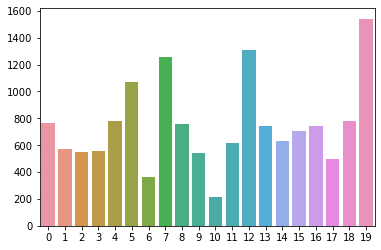

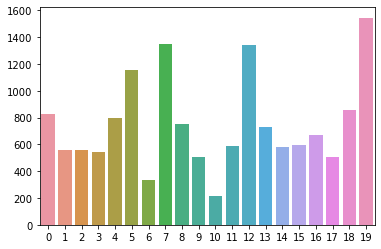

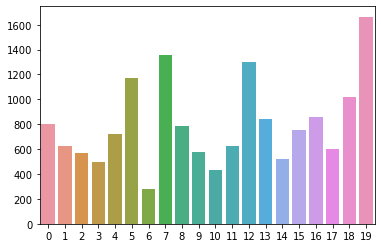

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   fragment_id  16000 non-null  int64
 1   behavior_id  16000 non-null  int64
dtypes: int64(2)
memory usage: 250.1 KB


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {
        0: 'A_1', 1: 'B_2', 2: 'A_3', 3: 'A_4', 4: 'B_3', 5: 'C_5', 6: 'C_2', 7: 'A_5', 8: 'B_1', 
        9: 'C_1', 10: 'A_2', 11: 'C_3',12: 'B_5', 13: 'B_4', 14: 'C_4', 
        15: 'D_6', 16: 'E_7', 17: 'F_8', 18: 'G_9', 19: 'H_0'
              }
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0

train_y = y
labels = np.argmax(proba_t[:,:20], axis=1)
oof_y = np.argmax(proba_oof[:,:20], axis=1)
print(round(accuracy_score(train_y, oof_y), 5))
scores = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(train_y, oof_y)) / oof_y.shape[0]
print(round(scores, 5))
data_path = '../data/'
sub = pd.read_csv(data_path+'submit_example.csv')
sub['behavior_id'] = labels

vc = pd.Series(train_y).value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()

vc = pd.Series(oof_y).value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()

vc = sub['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()
sub.to_csv('LSTM-Copy1_new-Copy1_LSTM_adddropout%.5f.csv' % scores, index=False)
sub.info()
